### Numerical Solution of the Burger's Equation

Burger's equation is a fundamental PDE and convection equation occuring in various fields of engineering and applied math. Burger's equation is a simplified form of the Navier-Stokes equations, which govern fluid motion, but it captures some essential features of fluid flow, particularly the balance between convection and diffusion. The one-dimensional Burger's equation is given by:

$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$

$u$ is the fluid velocity as a function of both space ($x$) and time (
$t$)

$\frac{\partial u}{\partial t}$ is the partial derivative of 
$u$ with respect to time


$\frac{\partial u}{\partial x}$ is the partial derivative of 
$u$ with respect to space

$\frac{\partial^2 u}{\partial x^2}$ is the second partial derivative of 
$u$ with respect to space

$\nu$ is the kinematic viscosity of the fluid


In two dimmension, it is given by: 
* U component

 $ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)$

* V component
  
 $\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)$
 

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation

In [2]:
# Define constants

nt = 500
nx = 51
ny = 51

nu = .1
dt = .001
dx = 2/(nx - 1)
dy = 2/(ny - 1)

In [3]:
# Establish grid points
x = np.linspace(0,2,nx)
y = np.linspace(0,2,ny)

# velocity containers
u  = np.zeros((nx,ny)) # current
v  = np.zeros((nx,ny))

un  = np.zeros((nx,ny)) # previous
vn  = np.zeros((nx,ny))
 
uf = np.zeros((nt,nx,ny)) # result container
vf = np.zeros((nt,nx,ny))

In [4]:
# Initial condition

# a small square is cut out from the square domain grid and we set the inner domain to have 5 times more speed than the outer square.
u = np.ones((ny, nx))
v = np.ones((ny, nx))
uf = np.ones((nt ,ny, nx))
vf = np.ones((nt ,ny, nx))

u[int(0.75/dy):int(1.25/dy+1) , int(0.75/dy):int(1.25/dy+1)] = 5
v[int(0.75/dy):int(1.25/dy+1) , int(0.75/dy):int(1.25/dy+1)] = 5

uf[0 ,int(0.75/dy):int(1.25/dy+1) , int(0.75/dy):int(1.25/dy+1)] = 5
vf[0 ,int(0.75/dy):int(1.25/dy+1) , int(0.75/dy):int(1.25/dy+1)] = 5

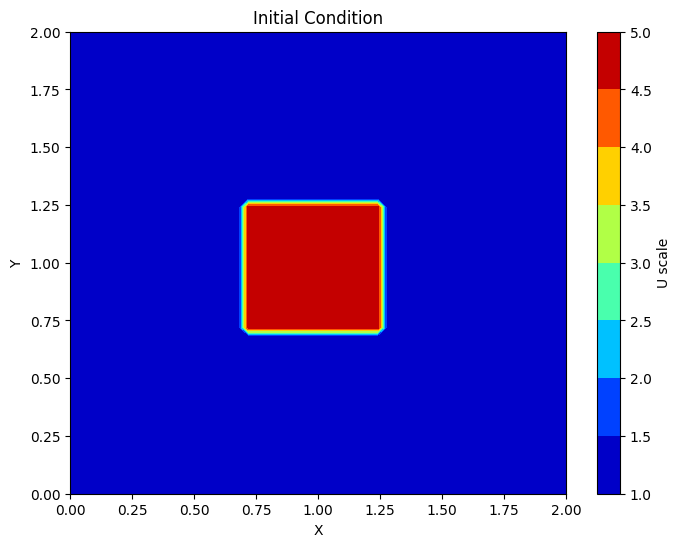

In [5]:
# Visualize Initial condition

X,Y = np.meshgrid(x,y)
plt.figure(figsize = (8,6))
contour = plt.contourf(X,Y,u, cmap = 'jet')
plt.title('Initial Condition')
plt.xlabel('X')
plt.ylabel('Y')
colorbar = plt.colorbar(contour)
colorbar.set_label('U scale')

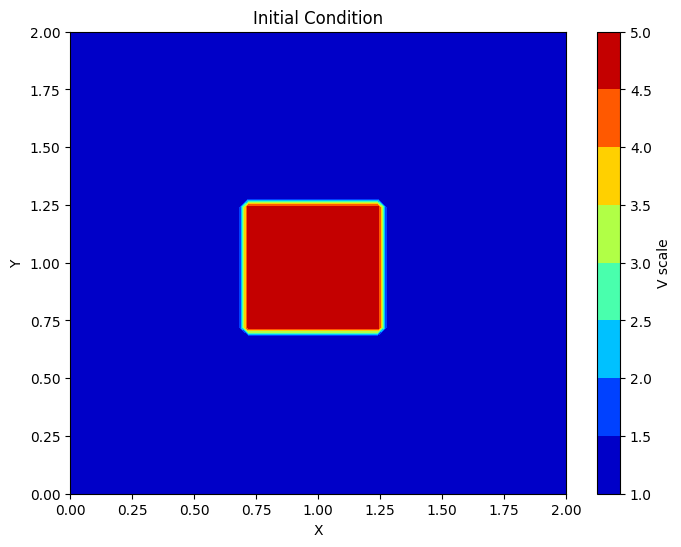

In [6]:
# Visualize Initial condition

X,Y = np.meshgrid(x,y)
plt.figure(figsize = (8,6))
contour = plt.contourf(X,Y,v, cmap = 'jet')
plt.title('Initial Condition')
plt.xlabel('X')
plt.ylabel('Y')
colorbar = plt.colorbar(contour)
colorbar.set_label('V scale')

Since we now have the Initial conditions set, let's generate the five point stencil for the u and v component of the velocity

 $\textbf{U component}$
  
$\frac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t} + u_{i,j}^n \frac{u_{i,j}^n - u_{i-1,j}^n}{\Delta x} + v_{i,j}^n \frac{u_{i,j}^n - u_{i,j-1}^n}{\Delta y} = \nu \left( \frac{u_{i+1,j}^n - 2u_{i,j}^n + u_{i-1,j}^n}{(\Delta x)^2} + \frac{u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n}{(\Delta y)^2} \right)
$

$\textbf{V component}$

$\frac{v_{i,j}^{n+1} - v_{i,j}^n}{\Delta t} + u_{i,j}^n \frac{v_{i,j}^n - v_{i-1,j}^n}{\Delta x} + v_{i,j}^n \frac{v_{i,j}^n - v_{i,j-1}^n}{\Delta y} = \nu \left( \frac{v_{i+1,j}^n - 2v_{i,j}^n + v_{i-1,j}^n}{(\Delta x)^2} + \frac{v_{i,j+1}^n - 2v_{i,j}^n + v_{i,j-1}^n}{(\Delta y)^2} \right)
$

$v_{i,j}^{n+1} = v_{i,j}^n - \Delta t \left( u_{i,j}^n \frac{v_{i,j}^n - v_{i-1,j}^n}{\Delta x} + v_{i,j}^n \frac{v_{i,j}^n - v_{i,j-1}^n}{\Delta y} \right) + \Delta t \nu \left( \frac{v_{i+1,j}^n - 2v_{i,j}^n + v_{i-1,j}^n}{(\Delta x)^2} + \frac{v_{i,j+1}^n - 2v_{i,j}^n + v_{i,j-1}^n}{(\Delta y)^2} \right)
$

In [7]:
# for t in range(1, nt):
#     un = u.copy()
#     vn = v.copy()
#     for i in range(1, nx-1):
#         for j in range(1, ny-1):
#             # u[i, j] = un[i, j] - dt * (un[i, j] * (un[i, j] - un[i-1, j]) / dx + vn[i, j] * (un[i, j] - un[i, j-1]) / dy) +\
#             #            dt * nu * ((un[i+1, j] - 2*un[i, j] + un[i-1, j]) / dx**2 + (un[i, j+1] - 2*un[i, j] + un[i, j-1]) / dy**2)

#             # v[i, j] = vn[i, j] - dt * (un[i, j] * (vn[i, j] - vn[i-1, j]) / dx + vn[i, j] * (vn[i, j] - vn[i, j-1]) / dy) +\
#             #            dt * nu * ((vn[i+1, j] - 2*vn[i, j] + vn[i-1, j]) / dx**2 + (vn[i, j+1] - 2*vn[i, j] + vn[i, j-1]) / dy**2)

#             u[i,j] = (un[i, j] -(un[i, j] * dt / dx * (un[i, j] - un[i-1, j])) -vn[i, j] * dt / dy * (un[i, j] - un[i, j-1])) + (nu*dt/(dx**2))*(un[i+1,j]-2*un[i,j]+un[i-1,j])+(nu*dt/(dx**2))*(un[i,j-1]-2*un[i,j]+un[i,j+1])
#             v[i,j] = (vn[i, j] -(un[i, j] * dt / dx * (vn[i, j] - vn[i-1, j]))-vn[i, j] * dt / dy * (vn[i, j] - vn[i, j-1])) + (nu*dt/(dx**2))*(vn[i+1,j]-2*vn[i,j]+vn[i-1,j])+(nu*dt/(dx**2))*(vn[i,j-1]-2*vn[i,j]+vn[i,j+1])
    

#             uf[t,i,j] = u[i,j]
#             vf[t,i,j] = v[i,j]

#     # Update BC

#     u[:,0], u[:,-1], u[0,:],u[-1,0] =1,1, 1,1
#     v[:,0], v[:,-1], v[0,:],v[-1,0] =1,1,1,1

In [8]:
for n in range(1, nt):
    un = u.copy()
    vn = v.copy()
    for i in range(1, nx-1):
        for j in range(1, ny-1): 
            u[i,j] = (un[i, j] -(un[i, j] * dt / dx * (un[i, j] - un[i-1, j])) -vn[i, j] * dt / dy * (un[i, j] - un[i, j-1])) + (nu*dt/(dx**2))*(un[i+1,j]-2*un[i,j]+un[i-1,j])+(nu*dt/(dx**2))*(un[i,j-1]-2*un[i,j]+un[i,j+1])
            v[i,j] = (vn[i, j] -(un[i, j] * dt / dx * (vn[i, j] - vn[i-1, j]))-vn[i, j] * dt / dy * (vn[i, j] - vn[i, j-1])) + (nu*dt/(dx**2))*(vn[i+1,j]-2*vn[i,j]+vn[i-1,j])+(nu*dt/(dx**2))*(vn[i,j-1]-2*vn[i,j]+vn[i,j+1])
            uf[n,i,j] = u[i,j]
            vf[n,i,j] = v[i,j]
    u[:,0 ] = 1
    u[:,-1] = 1
    u[0,: ] = 1
    u[-1,:] = 1
    v[:,0 ] = 1
    v[:,-1] = 1
    v[0,: ] = 1
    v[-1,:] = 1        


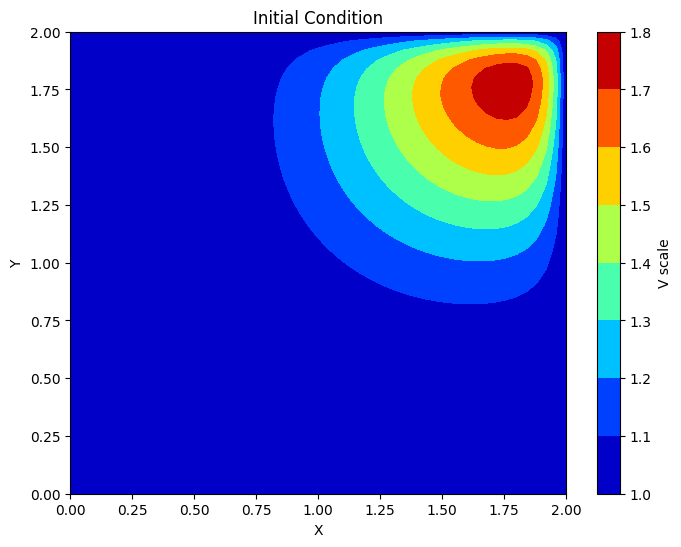

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(X, Y, u[:], cmap='jet')
plt.title('Initial Condition')
plt.xlabel('X')
plt.ylabel('Y')
colorbar = plt.colorbar(contour)
colorbar.set_label('V scale')

MovieWriter imagemagick unavailable; using Pillow instead.


Done!


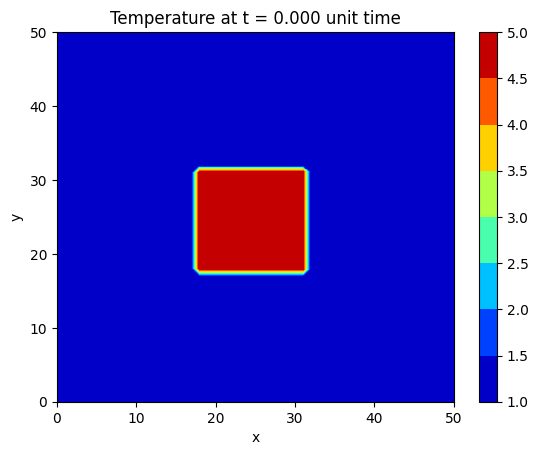

In [20]:
def plotheatmap(u_k, k):
    # Clear the current plot figure
    plt.clf()

    plt.title(f"Temperature at t = {k*dt:.3f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.contourf(u_k, cmap=plt.cm.jet)
    plt.colorbar()

    return plt



def animate(k):
    plotheatmap(uf[k], k)

# Create the animation
anim = FuncAnimation(plt.figure(), animate, interval=4, frames=nt, repeat=False)
anim.save("heat_equation_solution.gif", writer='imagemagick', fps=5)

print("Done!")